In [2]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

import mlflow

2024-09-30 17:51:54.945730: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 17:51:54.948990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 17:51:54.959340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 17:51:54.975249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 17:51:54.979668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 17:51:54.991694: I tensorflow/core/platform/cpu_feature_gu

# Classifying teeth to upper/lower jaw

In [67]:
mnist_model = tf.keras.models.load_model('/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras')

In [42]:
tooth_labels = pd.read_csv('/home/riikoro/fossil_data/tooth_samples/v3/upper_lower_labels.txt')
tooth_labels = tooth_labels[tooth_labels['upper (-1 = unknown)'] != -1] # -1 = unknown
tooth_labels['u'] = tooth_labels['upper (-1 = unknown)']
tooth_labels['l'] = abs(tooth_labels['u'] - 1)
del tooth_labels['upper (-1 = unknown)']
tooth_labels

,u,l
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
222,0,1
223,0,1
224,0,1
227,0,1


In [68]:
# for layer in mnist_model.layers[:-1]:
#     layer.trainable = False

new_output = Dense(2, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_3, built=True>]

In [69]:
for layer in new_model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True


In [56]:
def preprocess_img(image: np.array):
    image = image[:,:-12] #remove side pixels to get rid of number
    resized = cv2.resize(image,(28,28))
    colorflipped = 255-resized
    return colorflipped

In [57]:
original_images = glob.glob("/home/riikoro/fossil_data/tooth_samples/v3/*.png")

In [58]:
# convert teeth to images of shape 28x28, black and white
tooth_images = []
for i, filename in enumerate(original_images):
    img_index = int(filename.split('/')[-1].split('.')[0])
    if img_index in tooth_labels.index:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        tooth_images.append(preprocess_img(image))

teeth = np.array(tooth_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1) # add rgb dimension, required by model
teeth.shape

(220, 28, 28, 1)

In [59]:

X_train, X_val, Y_train, Y_val = train_test_split(teeth, tooth_labels, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(198, 28, 28, 1) (22, 28, 28, 1) (198, 2) (22, 2)


In [70]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 6 # in each iteration, we consider 128 training examples at once
num_epochs = 150
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [76]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 150, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

SyntaxError: unterminated string literal (detected at line 5) (448276758.py, line 5)

In [78]:
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=1)
print(f'Training accuracy: {train_acc}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6457 - loss: 0.6501
Training accuracy: 0.6515151262283325


In [79]:
test_loss, test_acc = model.evaluate(X_val, Y_val)
test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6364 - loss: 27.6484


0.6363636255264282

In [54]:
def id_to_upper_lower(id):
    if id == 0:
        return 'U'
    elif id == 1:
        return 'L'

correct = 0
fig, ax = plt.subplots(30, figsize = (500,30))
plt.subplots_adjust(hspace=2)
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_num = filename.split('/')[-1].split('.')[0]
    loc = int(img_num)
    label = tooth_labels.iloc[loc]

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred = id_to_upper_lower(np.argmax(pred))
    truth = id_to_upper_lower(np.argmax(label))
    fig_title = f'Predicted: {pred}, Correct: {truth}'
    if pred == truth:
        correct += 1
    
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

acc = correct/30
print(f"Accuracy: {acc} %")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


IndexError: single positional indexer is out-of-bounds

In [74]:
len(X_train)

198

In [80]:
%env MLFLOW_TRACKING_URI=sqlite:///../mlflow.db
mlflow.set_experiment("Upper / lower")

params = {
    'data_v': 3,
    'train_size':len(X_train),
    'test_size':len(X_val),
    'commit_sha': '6d312af',
    'batch_size': batch_size,
    'num_epochs': num_epochs
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", test_acc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Initial test with Fort Tenan Catalogue extractions")

env: MLFLOW_TRACKING_URI=sqlite:///../mlflow.db


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

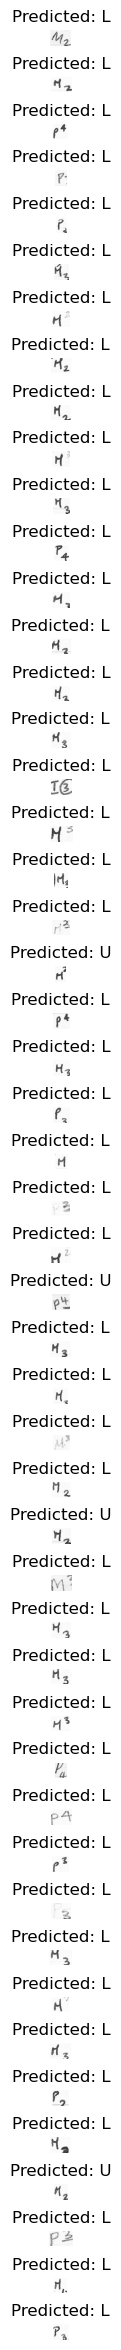

In [35]:
# testing: new tooth data upper/lower jaw inference

def id_to_upper_lower(id):
    if id == 0:
        return 'U'
    elif id == 1:
        return 'L'

correct = 0
fig, ax = plt.subplots(50, figsize = (500,30))
plt.subplots_adjust(hspace=2)
original_images = glob.glob('/home/riikoro/fossil_data/tooth_samples/v3/*.png')
for i, filename in enumerate(original_images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_num = filename.split('/')[-1].split('.')[0]
    # print(img_num)
    # break
    # loc = int(img_num)
    # label = type_labels.iloc[loc]

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred = id_to_upper_lower(np.argmax(pred))
    # truth = id_to_upper_lower(np.argmax(label))
    fig_title = f'Predicted: {pred}'
    # if pred == truth:
    #     correct += 1
    
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)
    if i == 49:
        break

# acc = correct/30
# print(f"Accuracy: {acc} %")